Most of our previous talk focused on **supervised learning** such as regression, SVM, DecisionTrees, etc. In the meaning of supervised learning, we usually have a dataset of features *$X_1, X_2, X_3, ..., X_p$* and total numbers of *n* observations on those features. Together we have a target vector *Y* indicating the classification class/value of each observation. And our work in supervised learning is to predict new *Y* with new feature vector *X* and our model.

And now we are going to talk about *unsupervised learning*, looking at several machine learning models which can work on just set of features *$X_1,X_2,X_3,...,X_p$* on *n* observations. Since we do not have a label/target vector *Y*, now we are not going to focus on prediction, but to figure out interesting patterns: like how to visualize our data? can we find certain sub-groups inside the data without labels?

#### What's the challenging of the unsupervised learning?
1. We do not have simple goal for the problem. In supervised learning, we can define loss function, or try to predict as accurately as possible. But in unsupervised learning, the problem can be more subjective.

2. Also it can be hard to build metrics to evaluate unsupervised learning models, and apply the techniques we have used in supervised learning for evaluation.

First lets look at:

# 1. Dimension Reduction

## Let's scatter plot some data first

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns; 
from sklearn.linear_model import LinearRegression

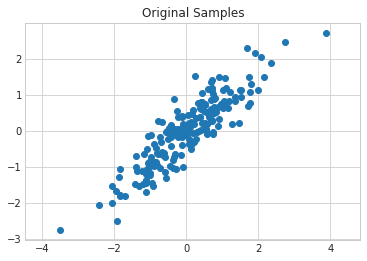

In [2]:
rng = np.random.RandomState(42)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

fig = plt.figure()
ax = plt.axes()

ax.scatter(X[:, 0], X[:, 1])
ax.set_title('Original Samples')
ax.axis('equal');

Now we have 2-dimensional dataset plotted. Can we reduce the dimension to be 1? Say figure out a line to represent the whole scatter plot. 

What if we do linear regression? Let's first try linear regression first
First X on Y:

In [3]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X[:,0].reshape(len(X[:,0]),1), X[:, 1])
lin_reg.intercept_, lin_reg.coef_

(-0.026749756891215545, array([0.81321907]))

Then Y on X :

In [4]:
lin_reg_inverse = LinearRegression(fit_intercept=True)
lin_reg_inverse.fit(X[:,1].reshape(len(X[:,1]),1), X[:, 0])
lin_reg_inverse.intercept_, lin_reg_inverse.coef_

(0.03487043177347125, array([0.9804529]))

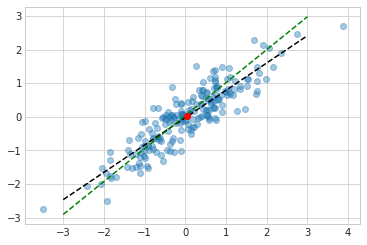

In [5]:
X_new_sample = np.array([[-3], [3]]) ## For generating the regression line
plt.plot(X_new_sample, lin_reg.predict(X_new_sample), "k--")
plt.plot(X_new_sample, lin_reg_inverse.predict(X_new_sample), "g--")
plt.scatter(X[:,0], X[:,1],alpha=0.4)
plt.plot(np.mean(X[:,0]), np.mean(X[:,1]), 'ro')
plt.show()

We have got two lines describing the linear relationship between two dimensions. Which can better describe the relationship/clustering of the data? And what about the correlations inside the dataset?

We need to do PCA to describe correlations and low-dimensional representations in our datasets

#### So what's PCA? And what can PCA do?

### Principal component analysis
**PCA figure out the most significant directions with largest sample variance**

Considering we have n observations with p features, $X_1, X_2, X_3, ..., X_p$, we would like to examining the dataset by plotting it in 2-dimensional scatter plots, each of which contains the n observations on 2 of the features. So there could be $p(p-1)/2$ such scatterplots. If we have 8 features, there would be 28 possible combinations. If $p$ is large, then it can be unrealistic to look at all of them. So we need to come up with some new features and a low-dimensional representation of the data to capture the information inside the dataset as much as possible.

PCA finds a low-dimensional representation of a data set that contains as much as possible of the variation. The
idea is that each of the n observations lives in $p-$dimensional space, but not
all of these dimensions are equally interesting. PCA seeks a small number
of dimensions that are as interesting as possible, where the concept of interesting is measured by the amount that the observations vary along each
dimension. Each of the dimensions found by PCA is a linear combination of the $p$ features. We now explain the manner in which these principal components are found and these more representative dimensions are built.

**The first principal component** of a set of features $X_1, X_2, X_3, ..., X_p$ is the normalized linear combination of the features:

$$Z_1 = \phi_{11}X_1 + \phi_{21}X_2 + ... + \phi_{p1}X_p$$ that has the largest variance. And the vector is normalized by such constraint: $\sum_{j=1}^p \phi_{j1}^2 = 1$ And we call $\phi_{11},...,\phi_{p1}$ as loadings of the principal component. We put them together to get a vector $\phi_1=(\phi_{11},\phi_{21}...,\phi_{p1})^T$

Since PCA only cares about the variance of the dataset, usually we need to center $X$ by substract the mean (make the mean of $X$ to be 0), and get the new data as $x_1, x_2, ... , x_p$

$$z_1 = \phi_{11}x_1 + \phi_{21}x_2 + ... + \phi_{p1}x_p$$

And the problem can be formulated as:

$$max_{\phi_1}{\frac{1}{n}\sum_{i=1}^{n}(\sum_{j=1}^{p}\phi_{j1}x_{ij})^2}$$

Subject to:
$$\sum_{j=1}^p \phi_{j1}^2 = 1$$

Usually we use matrix decomposition to solve this problem.

And once we get the first principal component, we can find **the second principal component** $Z_2$ which is uncorrelated with $Z_1$. The second principal component looks like 
$$z_{2} = \phi_{12}x_{i1} + \phi_{22}x_{i2} + ... + \phi_{p2}x_{ip} $$ Where $\phi_2=(\phi_{12},\phi_{22}...,\phi_{p2})^T$ is the loading vector of the second principal component.
And in order to make sure $Z_2$ is uncorrelated with $Z_1$, it's equivalent as to make sure $\phi_2$ is orthogonal to $\phi_1$. Still we use matrix decomposition to figure out the loading vector.

#### Before we dive into mathematics, we first take a look at how to do PCA in  Sklearn

In [6]:
## Generate 2-d PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pca.components_

array([[ 0.74306799,  0.66921593],
       [-0.66921593,  0.74306799]])

They should be orthogonal:

In [8]:
np.dot(pca.components_[0,:], pca.components_[1,:])

0.0

Two important attributes in PCA:

explained variance

In [9]:
pca.explained_variance_

array([1.82927343, 0.10246373])

explained variance ratio: which is  each explained variance/total variance

In [10]:
np.cumsum(pca.explained_variance_ratio_)

array([0.94695773, 1.        ])

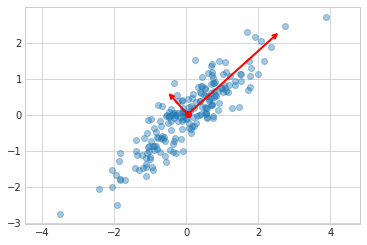

In [11]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color = 'r',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)
plt.plot(np.mean(X[:,0]), np.mean(X[:,1]), 'ro')
## pro rata scale the Principle compoment vector
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2.5 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

[(-3, 3.1),
 Text(0, 0.5, 'component 2'),
 (-5, 5),
 Text(0.5, 0, 'component 1'),
 Text(0.5, 1.0, 'principal components')]

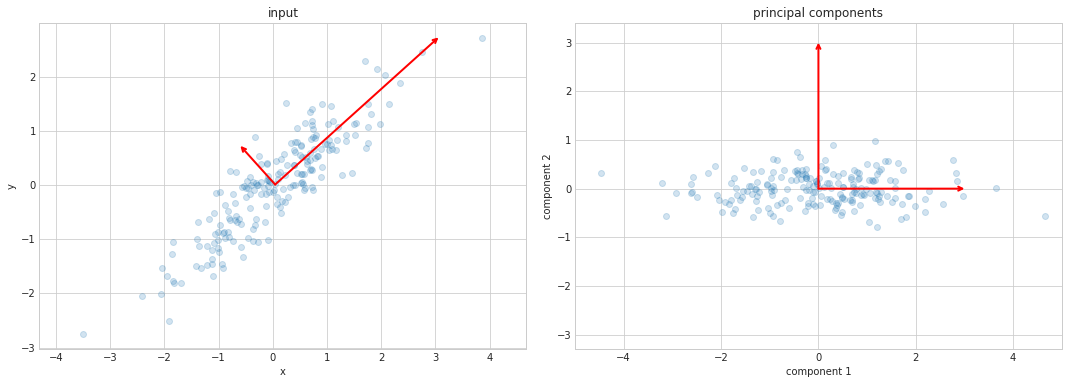

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')
## Here is 2-dim data doing PCA onto 2 major directions, 
## so actually we can explain all of them if we use 2 principle components


# plot principal components, for fitted X
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

### Project samples on to the principle components:
-- what's the difference between this projection and linear regression?

original shape:    (200, 2)
transformed shape: (200, 1)


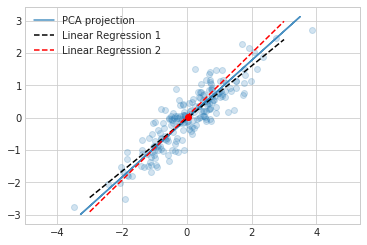

In [13]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], alpha=0.8, label='PCA projection')
plt.plot(X_new_sample, lin_reg.predict(X_new_sample), "k--", label='Linear Regression 1')



lin_reg_inverse = LinearRegression(fit_intercept=True)
lin_reg_inverse.fit(X[:,1].reshape(len(X[:,1]),1), X[:, 0])
X_new_inverse = np.array([[-3], [3]])
X_predict_inverse = lin_reg_inverse.predict(X_new_inverse)
plt.plot(X_new_inverse, X_predict_inverse, "r--", label='Linear Regression 2')
plt.plot(np.mean(X[:,0]), np.mean(X[:,1]), 'ro')
plt.legend()
plt.axis('equal');

#### While linear regression cannot serve as dimension reduction, PCA can.
If we project the datasets to principle compoments, we can get a compression of the original dataset

As we can see from the chart, PCA projection is different from the linear regression.
PCA describes the inner correlations of the datasets, while linear regression describes the bilateral linear relationship of the target vs regressor.
Now we have 3 lines, where are they going to cross each other?

#### Then we are going to use SVD Decomposition for PCA, 
so what's SVD?


Let's start from **spectrum decomposition, or eigen decomposition**:

For a *Real Symmetric Matrix $A$ ($N \times N$), $A$ can be decomposed as : $A = Q\Omega Q^T$, where $Q^T = Q^{-1}$, $Q$ is an orthogonal matrix, with i-th column $q_i$ as eigenvector of $A$, $\Omega = diag\{\lambda_1,...,\lambda_N\}, \lambda_1 \geq ... \geq \lambda_N \geq 0$ are all eigenvalues of $A$

We can also put it as 'A can be orthogonally diagonalized'.

Equivalently, $A^{-1} = (Q\Omega Q^T)^{-1} = Q\Omega^{-1}Q^T = Q(diag\{\lambda_1^{-1},...,\lambda_N^{-1}\})Q^T$

If we expand the expression, we get $$A = \sum_{j=1}^{N}\lambda_j q_j q^{'}_j$$

If $A$ is real but not symmetric, A is a N*N matrix with N linearly independent eigenvector, 
$A = Q\Omega Q^T$ still exists, however $Q$ is no longer orthogonal

So we can solve PCA by following steps:

1. Substract the mean of X
2. Calculate covariance matrix $C = \frac{1}{m}X X^T$
3. Do spectrum decomposition for $C$, rank the eigenvalues from top.
4. Get the first k eigenvectors and get the matrix $P_{k \times n}$ for transformation

The key of the problem is decomposing $C = \frac{1}{m}X X^T$

More generally, let's look at SVD decomposition:
$A : m*n, U: m*m, \Sigma: m*n, V: n*n$
$$A = U \Sigma V^T$$
Where $U$ is the left singular matrix, $V$ is the right singular matrix, and $\Sigma$ is the diagonized matrix with rank $k = rank(A)$

$A^TA = (U\Sigma V^T)^TU \Sigma V^T = V \Sigma^T U^TU \Sigma V^T = V\Sigma^T\Sigma V^T = V \Sigma^2 V^T$
So  $V$ is the orthogonal matrix from decomposing $A^TA$, and similarly $U$ is the orthogonal matrix from decomposing $AA^T$

The key of the problem is decomposing $A^TA$ and $AA^T$

So $$ A = \sum_{i=1}^k \sigma_i u_i v_i^T$$, where $u_i$ is the i-th column of $U$, so does $v_i$



To use SVD to do the PCA, we need to centralize the data first, substruct the mean of all dimensions:

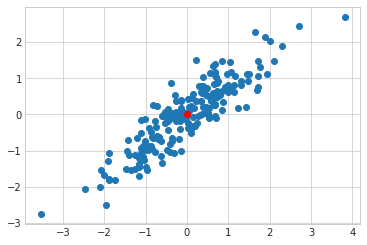

In [14]:
X_centered = X-X.mean(axis=0)
plt.plot(np.array([0]), np.array([0]), 'ro')
plt.scatter(X_centered[:,0], X_centered[:,1])

SVD Decomposition:
$$X = U \Sigma V^T$$

In [15]:
U, sigma, Vt = np.linalg.svd(X_centered)

In [16]:
## s is the diagram of the Sigma matrix
U.shape, sigma.shape, Vt.shape

((200, 200), (2,), (2, 2))

In [17]:
## Since numpy.linalg.svd returns a compact expression of the sigma matrix, we need to manually 
## expand the matrix to the correct dimension, which just adds 0 to the original matrix
m, n = X.shape
Sigma = np.zeros(X_centered.shape)
Sigma[:n, :n] = np.diag(sigma)

In [18]:
## Let's use np.allclose to see if the decomposition is the same as original matrix
np.allclose(np.dot(np.dot(U,Sigma),Vt) ,X_centered)

True

To generate the principle components, we just need to project the raw dataset like this:
$$X_{d_{project}} = XW_d$$
Where $W_d$ is the first d columns of $V^T$

In [19]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

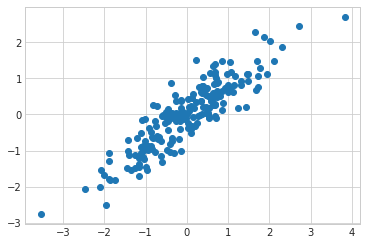

In [20]:
plt.scatter(X_centered[:,0], X_centered[:,1])

Now we have got the image of the  transformation, or equivalently, the location of each points under the projection onto principal components.

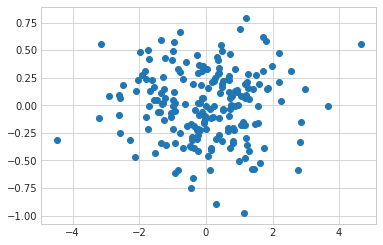

In [21]:
plt.scatter(X2D_using_svd[:,0], X2D_using_svd[:,1])

PCA inverse transformation, back to the original number of dimensions:
$$X_{recovered} = X_{d_{project}}W_d^T$$

Text(0.5, 1.0, 'Original vs Inverse Transform (SVD)')

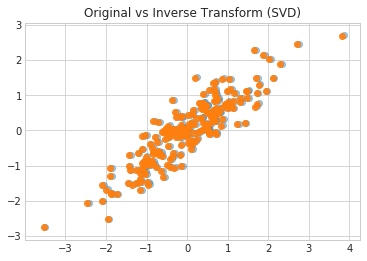

In [22]:
X_recovered = np.dot(X2D_using_svd, Vt.T[:, :2].T)
fig = plt.figure()
ax = plt.axes()
ax.scatter(X[:,0], X[:,1],  alpha=0.4)
ax.scatter(X_recovered[:,0], X_recovered[:,1], alpha=0.9)
ax.set_title('Original vs Inverse Transform (SVD)')

Seems they are really close, but do remember that we get *100%* explaining ratio for the 2-d decomposition.

So where is the difference?

-- The answer is centering.

Text(0.5, 1.0, 'Original vs Inverse Transform (SVD)')

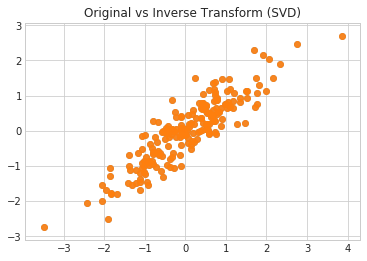

In [23]:
X_recovered = np.dot(X2D_using_svd, Vt.T[:, :2].T)
fig = plt.figure()
ax = plt.axes()
ax.scatter(X[:,0], X[:,1],  alpha=0.4)
ax.scatter(X_recovered[:,0] + X.mean(axis = 0)[0], X_recovered[:,1] + X.mean(axis=0)[1], alpha=0.9)
ax.set_title('Original vs Inverse Transform (SVD)')

In [24]:
np.allclose(X_recovered + X.mean(axis=0), X)

True

#### Let's Compare  SVD  Matrix Calculation vs SKlearn

In [25]:
pca_2d = PCA(n_components=1)
pca_2d.fit(X)
X_pca_2d = pca_2d.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca_2d.shape)

X_new_2d = pca_2d.inverse_transform(X_pca_2d)

original shape:    (200, 2)
transformed shape: (200, 1)


In [26]:
pca_2d.components_

array([[0.74306799, 0.66921593]])

In [27]:
X_new_2d.shape

(200, 2)

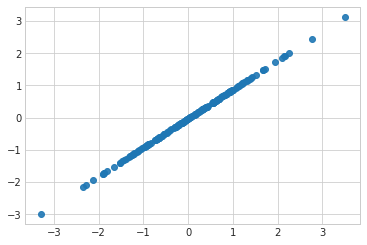

In [28]:
plt.scatter(X_new_2d[:,0], X_new_2d[:,1], alpha=0.9)

We can see that SVD is equivalent as PCA, so what's the benefit for us to turn a PCA problem into an SVD problem?

They are similar:

1. PCA's key is decomposing covariance matrix $C = \frac{1}{m}X X^T$
2. And SVD's key is decomposing $A^TA$

If we take $A = \frac{X^T}{\sqrt{m}}$, we have $A^TA = \frac{1}{m} X X^T$, then SVD is equivalent to PCA.

1. We can do less computing
2. Orthogonal decomposition algorithm is not very efficient
3. Beyond eigenvalue decomposition, SVD has other faster algorithm for solving, can avoid calculating $A^TA$

## Explained ratio for PCA
recall $$A = \sum_{j=1}^{N}\lambda_j q_j q^{'}_j$$
$\lambda_i$ is the eigenvalue of $A$, we can define explained ratio as $$R_k = \frac{\lambda_1+\lambda_2+...+\lambda_k}{\lambda_1+\lambda_2+...+\lambda_N}$$

This represents to what ratio the first k-th principle components explain the total variance of the original dataset.

In [29]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

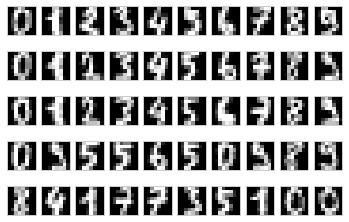

In [30]:
## Show MNIST dataset
fig, ax = plt.subplots(5, 10, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

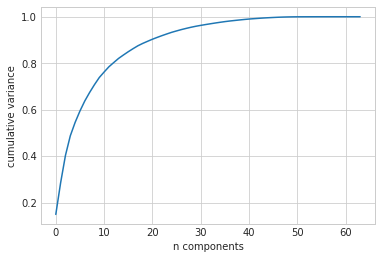

In [31]:
model = PCA(64).fit(digits.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

# 2. Clustering

## Introduction to K-Means:
The k-means algorithm searches for a predetermined number (k) of clusters with in an unlabeled multidimensional dataset.
The outcome of the algorithm should be like
1. The cluster center is some sort of arithmetic mean of all the points in the certain cluster
2. Each point is closest to its own cluster center.

Let's first take a look at some scatter plot of the dataset:

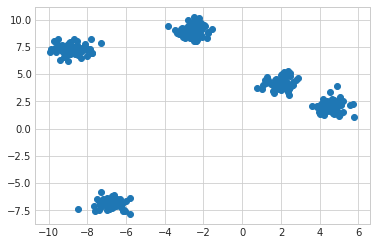

In [32]:
from sklearn.datasets import make_blobs
## Generate isotropic Gaussian blobs for clustering
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
plt.scatter(X[:, 0], X[:, 1]);

And it's easy to eye-screen that the dataset have 5 clusters. 
But how can computer/algorithm know that?

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans ## y_means is the predicted label of the data

array([1, 4, 1, 2, 1, 3, 4, 0, 3, 4, 2, 1, 2, 1, 4, 1, 2, 2, 4, 1, 1, 2,
       1, 4, 4, 1, 0, 4, 2, 0, 3, 4, 4, 3, 0, 2, 2, 4, 3, 2, 1, 2, 0, 3,
       4, 3, 1, 0, 4, 0, 3, 4, 0, 3, 1, 3, 2, 1, 3, 0, 1, 3, 4, 4, 0, 2,
       0, 0, 0, 0, 2, 0, 3, 4, 3, 1, 3, 3, 4, 1, 0, 1, 1, 4, 1, 0, 3, 2,
       2, 4, 4, 4, 1, 4, 1, 1, 4, 3, 2, 4, 3, 3, 2, 0, 1, 1, 1, 2, 1, 2,
       3, 4, 2, 2, 1, 1, 1, 0, 3, 3, 3, 0, 3, 3, 1, 0, 4, 4, 3, 1, 2, 3,
       2, 1, 1, 1, 1, 2, 0, 4, 1, 3, 1, 2, 4, 1, 4, 0, 2, 0, 2, 0, 0, 2,
       1, 4, 0, 3, 1, 2, 3, 3, 4, 2, 1, 3, 4, 4, 2, 4, 0, 1, 2, 2, 1, 2,
       3, 2, 0, 0, 3, 3, 2, 0, 0, 4, 1, 3, 0, 2, 4, 0, 1, 0, 0, 3, 3, 0,
       4, 2, 3, 0, 2, 2, 3, 1, 1, 0, 0, 1, 0, 3, 4, 0, 1, 2, 3, 3, 0, 4,
       3, 3, 4, 3, 4, 2, 3, 4, 3, 4, 3, 2, 2, 0, 4, 2, 2, 2, 4, 1, 3, 2,
       0, 4, 0, 3, 4, 4, 0, 0, 2, 4, 3, 0, 3, 4, 0, 4, 0, 4, 0, 1, 4, 2,
       2, 1, 4, 2, 0, 2, 3, 0, 0, 1, 1, 3, 2, 2, 4, 4, 3, 1, 1, 2, 2, 0,
       0, 0, 4, 2, 3, 2, 0, 3, 1, 3, 0, 1, 4, 1], d

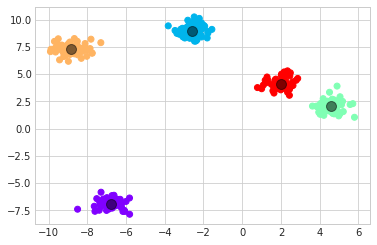

In [34]:
## Color map of rainbow can let you choose how many colors need to be included
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans,  cmap=plt.cm.get_cmap('rainbow', 5))

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

So it's quite close to our intuitive. But how does the magic happen?

- Specify number of clusters K

- Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement

- Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.


#### E-M Algorithm is a generalized form of k-Means
**E-M Algorithm steps:**
1. Initiate some cluster centers by guessing
2. **'E'xpectation**: each point assigned to nearest cluster center, updating expectation of      which cluster each point belongs to.
   
   **'M'aximization**: maximize the fitness 
3. Repeat step 2 until converge

Objective function: For total $m$ points and $K$ clusters:
$$J = \sum_{i=1}^{m}\sum_{k=1}^Kw_{ik}||x^i - \mu_k||^2$$
Where $W_{ik}=1$ for data point $X_i$ if it belongs to cluster k; otherwise $W_{ik}=0$. And $\mu_k$ is the centroid of $x_i$'s cluster

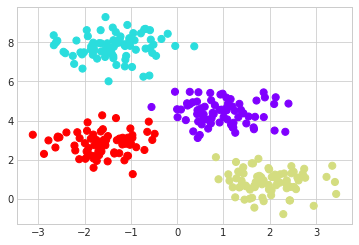

In [35]:
## Implementation of K-Means
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
centers, labels = find_clusters(X, n_clusters=4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 4));

### Potential problems:
- May not be able to find global optimum

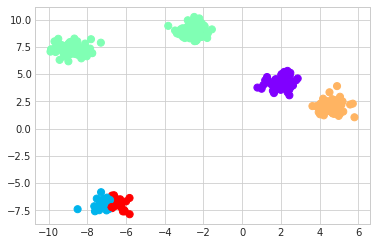

In [36]:
## Try to change the random seed
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
centers, labels = find_clusters(X, 5, rseed=15)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 5));

- We need to assign a number k previous to we know about the data

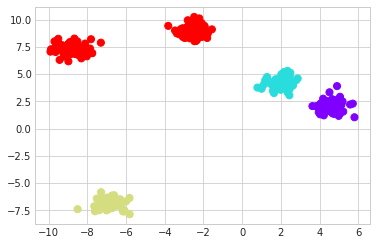

In [37]:
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
centers, labels = find_clusters(X, 4, rseed=42)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 4));

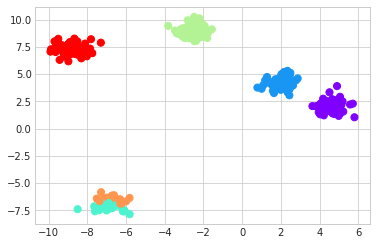

In [38]:
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
centers, labels = find_clusters(X, 6, rseed=42)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 6));

- Limited to linear clusters

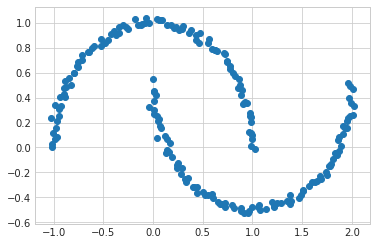

In [39]:
from sklearn.datasets import make_moons
X_moon, y_moon = make_moons(200, noise=0.02, random_state=42)
plt.scatter(X_moon[:,0], X_moon[:,1])

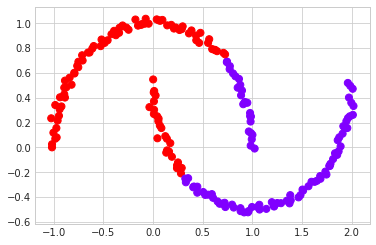

In [40]:
## Self- implemented K-Means:
centers, labels = find_clusters(X_moon, 2, rseed=42)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels,
            s=50, cmap = plt.cm.get_cmap('rainbow', 2));

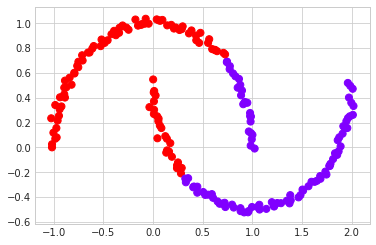

In [41]:
## K-Means from Sklearn:
labels = KMeans(2, random_state=0).fit_predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels,
            s=50, cmap=plt.cm.get_cmap('rainbow', 2));

- How to fix this issue? Let's try kernal tricks similar to the one we have applied in SVM

/home/rw2694/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


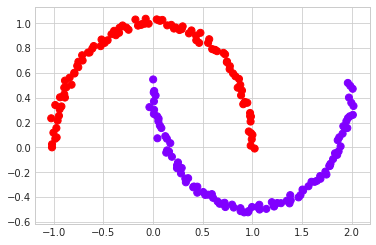

In [42]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 2));

- K-Means can be slow for large datasets

## K-means on digits

In [43]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

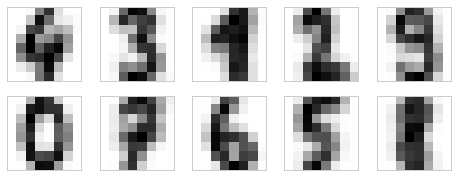

In [45]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [46]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

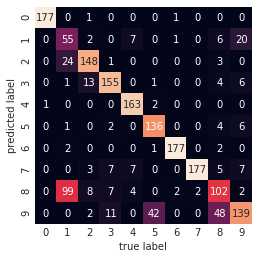

In [48]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## K-means for color compression

One interesting application of clustering is in color compression within images.

In [49]:
import warnings
warnings.simplefilter('ignore')  
from sklearn.cluster import MiniBatchKMeans

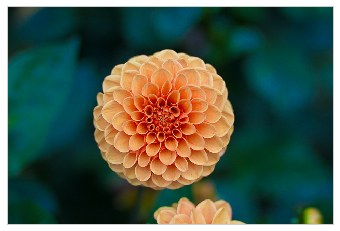

In [50]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

In [51]:
flower.shape

(427, 640, 3)

This image consists 3 dimensions: height * width * color, each height * width is a pixel, and in total it has 427*640 pixels, 427*640 is also the resolution of this image. Color itself contains 3 dimensions, too. A very classical solution for color encoding is RGB, which is also applied here. 3-d array (R,G,B) in each pixel can represent the actual color of the certain pixel. 
https://en.wikipedia.org/wiki/RGB_color_model

In [52]:
255*255*255

16581375

Full RGB encoding can have an image with 16581375 different colors.
While in most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

In [53]:
flower_data = flower / 255.0  ## use 0...1 scale to normalize color data.
flower_data = flower_data.reshape(427 * 640, 3) ## Reshape into 2-d array, strench the image into vector
flower_data.shape

(273280, 3)

In [54]:
def plot_pixels(data, title, colors=None):
    if colors is None:
        colors = data
    N=100000
    # choose a random subset
    rng = np.random.RandomState(42)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    ax[0].set_title('Green vs Red')

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [55]:
## Import for plotting in 3-D
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'Input color space: 16 million possible colors')

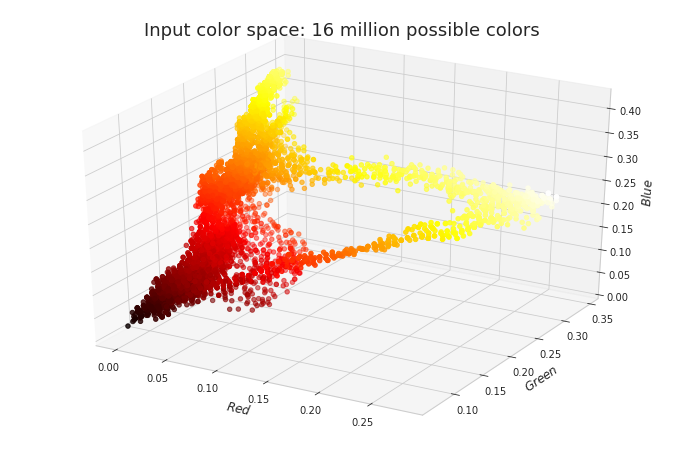

In [56]:
colorset = flower_data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
N_samples = 10000
c_map = (colorset[:N_samples][:,0] + colorset[:N_samples][:,1] + colorset[:N_samples][:,2])/3
cmhot = plt.get_cmap("hot")
ax.scatter(colorset[:N_samples][:,0], colorset[:N_samples][:,1], colorset[:N_samples][:,2], c=c_map,cmap=cmhot)
ax.set_xlabel("$Red$", fontsize=12)
ax.set_ylabel("$Green$", fontsize=12)
ax.set_zlabel("$Blue$", fontsize=12)
ax.set_title('Input color space: 16 million possible colors',fontsize=18)

Text(0.5, 0.92, 'Reduced color space: 16 colors')

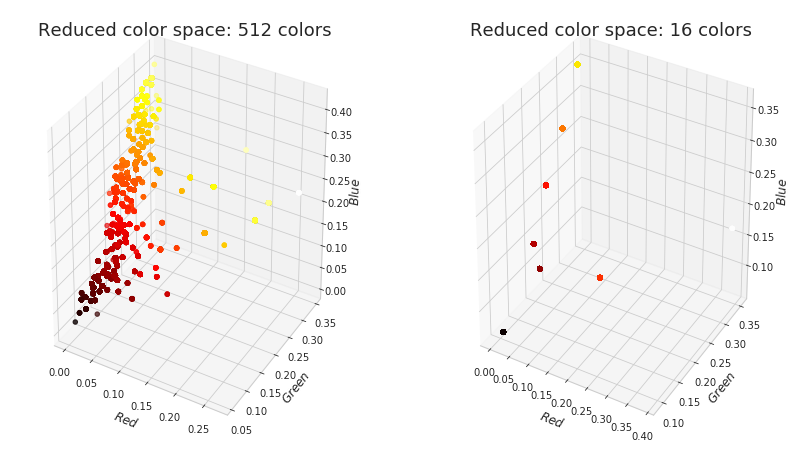

In [57]:
fig = plt.figure(figsize=(14, 8))

kmeans = MiniBatchKMeans(512)
kmeans.fit(flower_data)
new_flower_data = kmeans.cluster_centers_[kmeans.predict(flower_data)]
colorset = new_flower_data
ax = plt.subplot(121, projection='3d')
N_samples = 10000
c_map = (colorset[:N_samples][:,0] + colorset[:N_samples][:,1] + colorset[:N_samples][:,2])/3
cmhot = plt.get_cmap("hot")
ax.scatter(colorset[:N_samples][:,0], colorset[:N_samples][:,1], colorset[:N_samples][:,2], c=c_map,cmap=cmhot)
ax.set_xlabel("$Red$", fontsize=12)
ax.set_ylabel("$Green$", fontsize=12)
ax.set_zlabel("$Blue$", fontsize=12)
ax.set_title("Reduced color space: 512 colors",fontsize=18)

kmeans = MiniBatchKMeans(16)
kmeans.fit(flower_data)
new_flower_data = kmeans.cluster_centers_[kmeans.predict(flower_data)]
colorset = new_flower_data
ax =  plt.subplot(122, projection='3d')
N_samples = 10000
c_map = (colorset[:N_samples][:,0] + colorset[:N_samples][:,1] + colorset[:N_samples][:,2])/3
cmhot = plt.get_cmap("hot")
ax.scatter(colorset[:N_samples][:,0], colorset[:N_samples][:,1], colorset[:N_samples][:,2], c=c_map,cmap=cmhot)
ax.set_xlabel("$Red$", fontsize=12)
ax.set_ylabel("$Green$", fontsize=12)
ax.set_zlabel("$Blue$", fontsize=12)
ax.set_title("Reduced color space: 16 colors",fontsize=18)

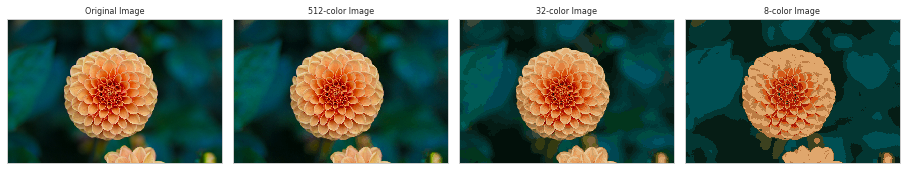

In [58]:
reduced_color_dim = [512, 32, 8]
dimreduced_flower = {}
for new_dim in reduced_color_dim:
    
    kmeans = MiniBatchKMeans(new_dim)
    kmeans.fit(flower_data)
    new_flower_data = kmeans.cluster_centers_[kmeans.predict(flower_data)]
    dimreduced_flower.update({new_dim:new_flower_data})

# flower_recolored = new_flower_data.reshape(flower.shape)

fig, ax = plt.subplots(1, 4, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)

ax[0].imshow(flower)
ax[0].set_title('Original Image', size=8)

ax[1].imshow(dimreduced_flower[512].reshape(flower.shape))
ax[1].set_title('512-color Image', size=8);

ax[2].imshow(dimreduced_flower[32].reshape(flower.shape))
ax[2].set_title('32-color Image', size=8);

ax[3].imshow(dimreduced_flower[8].reshape(flower.shape))
ax[3].set_title('8-color Image', size=8);

## 3. Classification

K Nearest Neighbor(KNN) is a very simple, easy to understand, versatile and one of the topmost machine learning algorithms.KNN algorithm used for both classification and regression problems. KNN algorithm based on feature similarity approach.

KNN is **non-parametric** and **lazy** learning algorithm. 

1. Non-parametric means there is no parameter to train in the algorithm, and no assumption for underlying data distribution.  

2. Lazy means all training data used in the testing phase. This makes training faster and testing phase slower and costlier.

### What's the K-NN algorithm?

In KNN, K is the number of nearest neighbors. The number of neighbors is the core deciding factor. 

K is generally an odd number if the number of classes is 2. 
When K=1, then the algorithm is known as the nearest neighbor algorithm. This is the simplest case. Suppose P1 is the point, for which label needs to predict. First, you find the one closest point to P1 and then the label of the nearest point assigned to P1.

In [59]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import preprocessing
%matplotlib inline

In [60]:
iris = datasets.load_iris()

# take the first two features
X = iris.data[:, :2]
y = iris.target

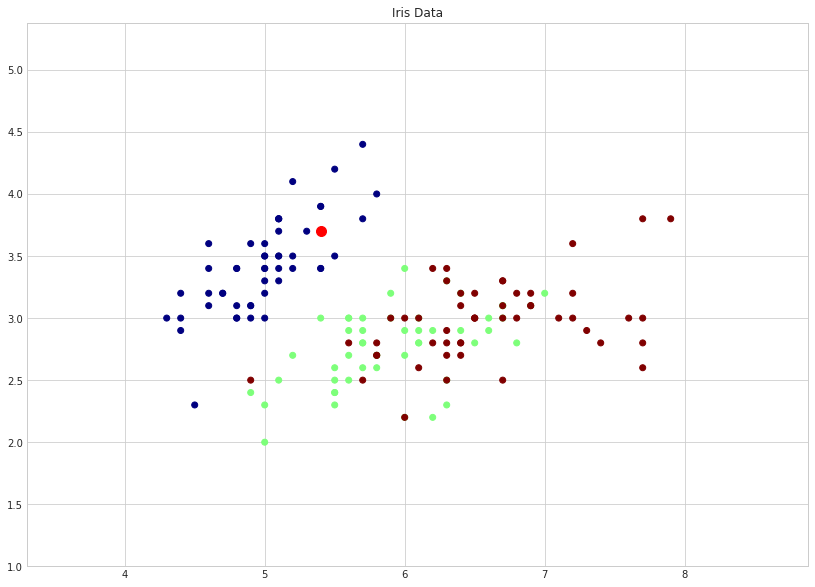

In [61]:
h = .02  # step size in the mesh

# Calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Put the result into a color plot
fig =plt.figure(figsize=(14,10))
ax = plt.axes()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("Iris Data")
ax.scatter(X[:, 0][10], X[:, 1][10], s = 100, facecolors='red')

Text(0.5, 1.0, '3-Class classification (k = 2)')

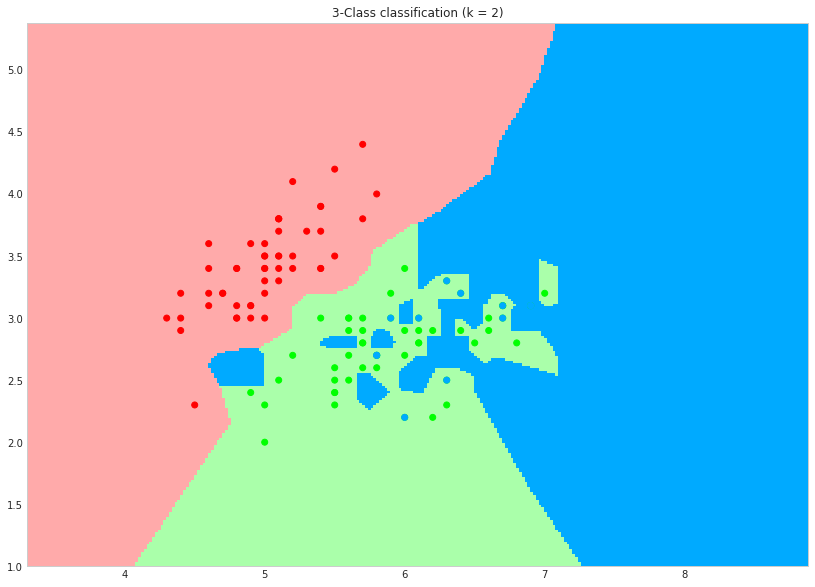

<Figure size 432x288 with 0 Axes>

In [62]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

n_neighbors=2
# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
clf.fit(X, y)

# calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


fig = plt.figure(figsize=(14,10))
ax = plt.axes()
Z = Z.reshape(xx.shape)
plt.figure()
ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("3-Class classification (k = %i)" % (n_neighbors))

In [63]:
n_neighbors = 6

# import some data to play with
iris = datasets.load_iris()

# prepare data
X = iris.data[:, :2]
y = iris.target
h = .02

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X, y)
clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1])

Advantages:

The training phase of K-nearest neighbor classification is much faster compared to other classification algorithms. There is no need to train a model for generalization, That is why KNN is known as the simple and instance-based learning algorithm. KNN can be useful in case of nonlinear data. It can be used with the regression problem. Output value for the object is computed by the average of k closest neighbors value.

Disadvantages:

The testing phase of K-nearest neighbor classification is slower and costlier in terms of time and memory. It requires large memory for storing the entire training dataset for prediction. KNN requires scaling of data because KNN uses the Euclidean distance between two data points to find nearest neighbors. Euclidean distance is sensitive to magnitudes. The features with high magnitudes will weight more than features with low magnitudes. KNN also not suitable for large dimensional data.